In [1]:
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import classification_report
from tqdm import tqdm
from _posture_detection_model import PostureDetectionModel
from _posture_detection_dataset import PostureDetectionDataset

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
input_channels = 3
channel_sequence_dim = 200
output_class = 5
Model_Name = "posture_detection_model"

Num GPUs Available:  1


In [3]:
train_dataset = PostureDetectionDataset('data/processed/train/', batch_size=8, shuffle=True)
val_dataset = PostureDetectionDataset('data/processed/valid/', batch_size=2, shuffle=True)
test_dataset = PostureDetectionDataset('data/processed/test/', batch_size=1, shuffle=False)

print("train_dataset:", len(train_dataset))
print("val_dataset:", len(val_dataset))
print("test_dataset:", len(test_dataset))

Found 4240 files in Folder data/processed/train/


100%|██████████| 4240/4240 [00:22<00:00, 190.34it/s]


Found 530 files in Folder data/processed/valid/


100%|██████████| 530/530 [00:03<00:00, 157.85it/s]


Found 531 files in Folder data/processed/test/


100%|██████████| 531/531 [00:00<00:00, 1099.05it/s]

train_dataset: 530
val_dataset: 265
test_dataset: 531


In [4]:
data, label, window = train_dataset[100]
print(data.shape)
print(label.shape)
print(window)

(8, 200, 3)
(8, 5)
[309, 3735, 2661, 5282, 2099, 832, 857, 2107]


In [5]:
model = PostureDetectionModel(input_channels, channel_sequence_dim, output_class)

In [6]:
model.build(input_shape=(4, 200, 3))
model.summary(expand_nested=True)

Model: "posture_detection_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 5)                 23845     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| gru (GRU)                 (None, 80)                20400     |
|                                                               |
| dense (Dense)             (None, 40)                3240      |
|                                                               |
| dropout (Dropout)         (None, 40)                0         |
|                                                               |
| dense_1 (Dense)           (None, 5)                 205       |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
Total params: 23,845
Trainable params: 23,845
Non-trainable params: 0
_________________________________________________________________


In [7]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss_fn = keras.losses.CategoricalCrossentropy()

In [8]:
def train(optimizer, criterion):
    print("Training the Model...")
    loss_metric = keras.metrics.Mean()
    with tf.device('/device:GPU:0'):
        for step, x_batch_train in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                data, label, window = x_batch_train
                # Forward pass
                output = model(data, training=True)
                # Compute loss
                loss = criterion(label, output)
                loss += sum(model.losses)
                
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

    return loss_metric.result()

def validation(criterion):
    print("Validating the Model...")
    loss_metric = keras.metrics.Mean()
    with tf.device('/device:GPU:0'):
        for step, x_batch_validation in enumerate(val_dataset):
            data, label, window = x_batch_validation
            # Forward pass
            output = model(data, training=False)
            # Compute loss
            loss = criterion(label, output)
            loss += sum(model.losses)
            
            loss_metric(loss)

    return loss_metric.result()

def test():
    print("Testing the Model...")
    
    y_true = []
    y_pred = []

    for step, x_batch_test in enumerate(test_dataset):
        data, label, window = x_batch_test
        # Forward pass
        output = model(data, training=False)
        # Convert to 1 hot encoding
        predicted = tf.argmax(output, axis=1)
        label = tf.argmax(label, axis=1)

        y_true.append(label)
        y_pred.append(predicted)
        
    concat_y_true = tf.concat(y_true, axis=0)
    concat_y_pred = tf.concat(y_pred, axis=0)

    print(classification_report(concat_y_true, concat_y_pred))


In [9]:
epochs = 20

train_losses = []
valid_losses = []

# Iterate over epochs.
for epoch in range(epochs):
    train_loss = train(optimizer, loss_fn)
    train_losses.append(train_loss)

    val_loss = validation(loss_fn)
    valid_losses.append(val_loss)

    print("Epoch %d: train loss = %.4f, val loss = %.4f" % (epoch, train_loss, val_loss))

test()

Training the Model...
Validating the Model...
Epoch 0: train loss = 1.4637, val loss = 1.2891
Training the Model...
Validating the Model...
Epoch 1: train loss = 1.3380, val loss = 1.1785
Training the Model...
Validating the Model...
Epoch 2: train loss = 1.2797, val loss = 1.1105
Training the Model...
Validating the Model...
Epoch 3: train loss = 1.2317, val loss = 1.0615
Training the Model...
Validating the Model...
Epoch 4: train loss = 1.1930, val loss = 1.0220
Training the Model...
Validating the Model...
Epoch 5: train loss = 1.1669, val loss = 0.9784
Training the Model...
Validating the Model...
Epoch 6: train loss = 1.1382, val loss = 0.9505
Training the Model...
Validating the Model...
Epoch 7: train loss = 1.1204, val loss = 0.9257
Training the Model...
Validating the Model...
Epoch 8: train loss = 1.0820, val loss = 0.8954
Training the Model...
Validating the Model...
Epoch 9: train loss = 1.0466, val loss = 0.8668
Training the Model...
Validating the Model...
Epoch 10: trai

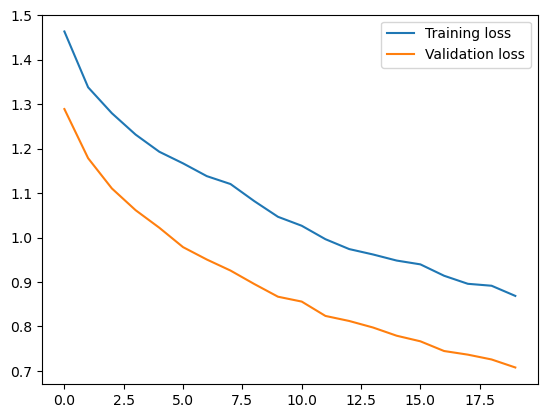

In [10]:
#plotting the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.savefig('losses - relu activated.png')
plt.show()

In [11]:
# Assume 'model' is your trained model
model.save_weights(Model_Name + '.h5')

In [13]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open(Model_Name + '.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Aninda\AppData\Local\Temp\tmp8ma_ia8z\assets


INFO:tensorflow:Assets written to: C:\Users\Aninda\AppData\Local\Temp\tmp8ma_ia8z\assets


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}